### Code GAN
Target is to go from $p_z \to p_{\delta, \text{ gauss or uniform}}$, where conventionally $z \sim \mathcal{N}(0, 1)$

Enough `Babble'-ing, CODE Please!!!

In [190]:
!pip install torchmetrics torchquad statsmodels
!apt install texlive
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 3.5 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 1.7 MB/s eta 0:00:004.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 693.5 kB/s eta 0:00:0031m6.7 MB/s eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simple-driving 0.0.1 requires pybullet, which is not installed.
fastai 2.2.7 requires torch<1.8,>=1.7.0, but you have torch 1.10.1+cu113 which is incompatible.
fastai 2.2.7 requires torchvision<0.9,>=0.8, but you have torchvision 0.11.2+cu113 which is incompatible.
--- Logging 

In [2]:
import torch.nn as nn
import torch
from torchmetrics import Accuracy
# from torchvision.datasets import FashionMNIST
# from torchvision import transforms
# from torch.utils.data import  DataLoader
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 15
import sys
from sklearn.utils import shuffle

cuda = True if torch.cuda.is_available() else False
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.manual_seed(0)

#### Create Data
 Given $\delta, \mathcal{N}(\mu, \sigma) \text{ or } U[\min, \max]$ of which $\mathcal{N}(\mu, \sigma)$ is not periodic though in $[-\pi, \pi]$, so lets consider $\mathcal{N}(0, \sigma)$ to make it more or less symetrric over $[-\pi, \pi]$.

 Now we will sample some points from $[-\pi, \pi]$ and pass it through any of the function at a time. Sampling 1L points in (100, 100, 1) dim.

In [3]:
class DataModule:
    def __init__(self,dim, normalize=True, **kwargs):
        # a 3-D X : (batchs, numbers, 1)
        # and we will follow the -π to π for initial experiments
        if kwargs['f'] == 'delta':
            self.p = self.delta()
        elif kwargs['f'] == 'gauss':
            self.X = np.random.normal(loc=kwargs['mu'], scale=kwargs['sigma'], size=dim)
            if normalize:
                self.scale = (self.X.max() - self.X.min())
                self.X = self.X / self.scale
            self.p = self.gauss(kwargs['mu'], kwargs['sigma'])
        elif kwargs['f'] == 'uniform':
            self.X = np.random.uniform(kwargs['min'], kwargs['max'], size=dim)
            if normalize:
                self.scale = (self.X.max() - self.X.min())
                self.X = self.X / self.scale
            self.p = self.uniform(kwargs['min'], kwargs['max'])
        train_ratio = int(0.8*len(self.X))
        self.X_train, self.X_test = self.X[:train_ratio], self.X[train_ratio:]
        self.X_train, self.X_test  = Variable(Tensor(self.X_train)),Variable(Tensor(self.X_test))

    def delta(self):
        dim = self.X.shape
        return np.where(self.X == 0, np.inf*np.ones(dim), np.zeros(dim))

    def gauss(self, mu, sigma):
        return np.exp(-0.5*((self.X-mu)/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

    def uniform(self, min, max):
        dim = self.X.shape
        return 1 / (max - min) * np.ones(dim)

#### Generator and Discriminator

In [4]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                nn.Linear(1, 4),
                nn.LeakyReLU(0.01),
                nn.Linear(4,4),
                nn.LeakyReLU(0.01),
                nn.Linear(4,4),
                nn.LeakyReLU(0.01),
                nn.Linear(4, 1),
                nn.Tanh()
            )

    def forward(self, z):
        y_gen = self.model(z)
        return y_gen


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1, 8),   #8,
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid(),
        )

    def forward(self, fn):
        validity = self.model(fn)
        return validity


adversarial_loss = nn.BCELoss()


## **$\mathcal{N}(0,1) \to \mathcal{N}(-200,1)$**

### Vanilla GAN

In [5]:
!rm -r Log
!mkdir Log
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)



data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 1000/1000] [Batch 80/80] [D loss: 0.000526] [G Loss: 6.884997] [Generated: 0.443299]

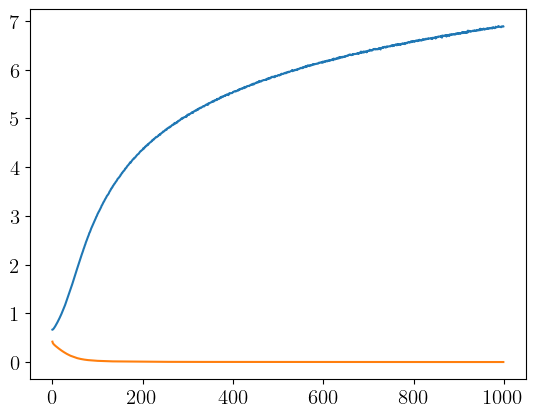

In [6]:

epochs = 1000
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.normal(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        real_loss = adversarial_loss(discriminator(f), lbl_one)
        fake_loss = adversarial_loss(discriminator(f_tilde), lbl_zero)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(f_tilde.detach()), lbl_one)
        g_loss.backward()
        optimizer_G.step()
        if (e%10 == 0):
            torch.save(generator, "./Log/Generaor_%d"%(e))

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

    
plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis

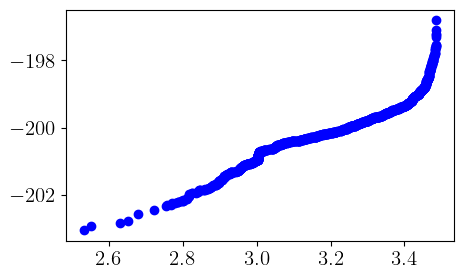

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [7]:
noisetype = "Normal(0,1)"
GAN = "Vanilla GAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

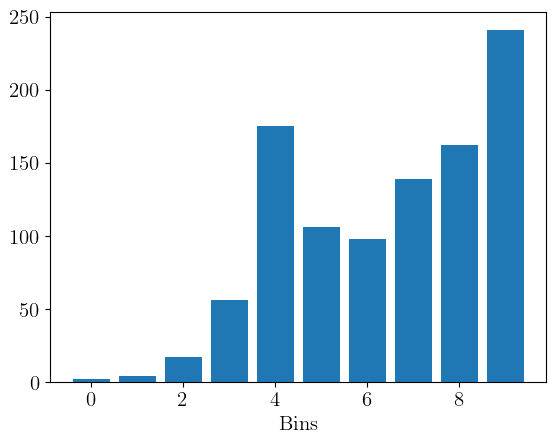

In [8]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [9]:
res = stats.anderson(x1, dist='norm')
print(res)

AndersonResult(statistic=19.2795349153007, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [11]:
with open("./M/RUN2/N/VGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### W-GAN

In [12]:

generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 200/200] [Batch 80/80] [D loss: -0.227962] [G Loss: -0.436137] [Generated: -0.999880]

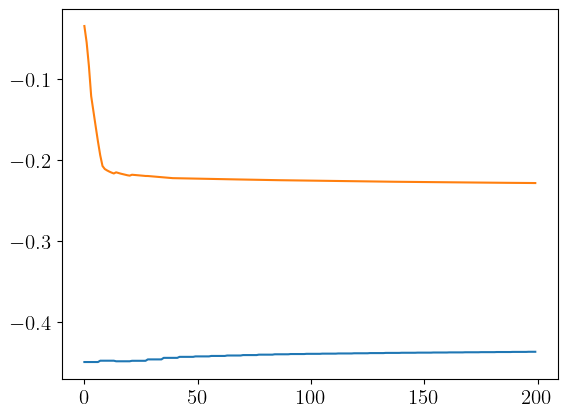

In [13]:

epochs = 200
gloss, dloss = [], []
clip_value = 0.2
n_critic = 7


batches_done = 0
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        z = Variable(Tensor(np.random.normal(size=dimn)))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Generate a batch of images
        f_tilde = generator(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(discriminator(f)) + torch.mean(discriminator(f_tilde))

        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if e % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            f_tilde = generator(z)
            # Adversarial loss
            g_loss = -torch.mean(discriminator(f_tilde))

            g_loss.backward()
            optimizer_G.step()

        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))

        batches_done += 1
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of W-GAN

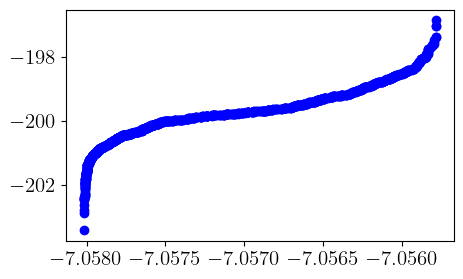

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [14]:
noisetype = "Normal(0,1)"
GAN = "W-GAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s GAN'%(noisetype, 1000, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

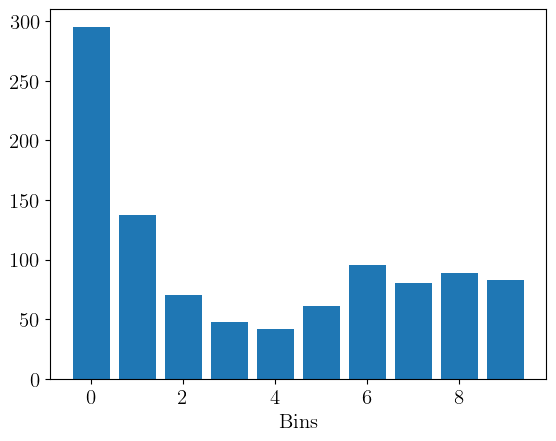

In [15]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [16]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=41.64745416995265, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [17]:
with open("./M/RUN2/N/WGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### LS-GAN


In [18]:
'https://github.com/meliketoy/LSGAN.pytorch/blob/master/main.py'
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)



data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1, normalize=False)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.012158] [G Loss: 0.304171] [Generated: -0.432999]

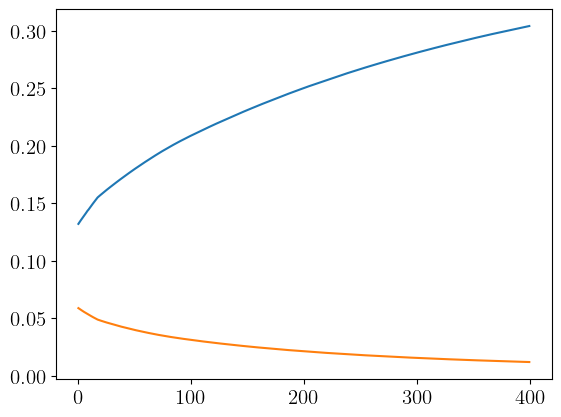

In [19]:

epochs = 400
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.normal(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        errD_real = 0.5 * torch.mean((discriminator(f) - lbl_one)**2)
        errD_fake = 0.5 * torch.mean((discriminator(f_tilde) - lbl_zero)**2)
        d_loss = (errD_fake + errD_real) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = 0.5 * torch.mean((discriminator(f_tilde.detach()) - lbl_one)**2) # criterion(output, label)
        g_loss.backward()
        optimizer_G.step()

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of LSGAN

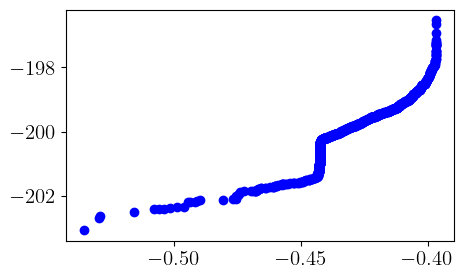

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [20]:
noisetype = "Normal(0,1)"
GAN = "LSGAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten()
x1 = f_tilde.detach().cpu().numpy()
x2 = Xt_test.flatten().detach().cpu().numpy()
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

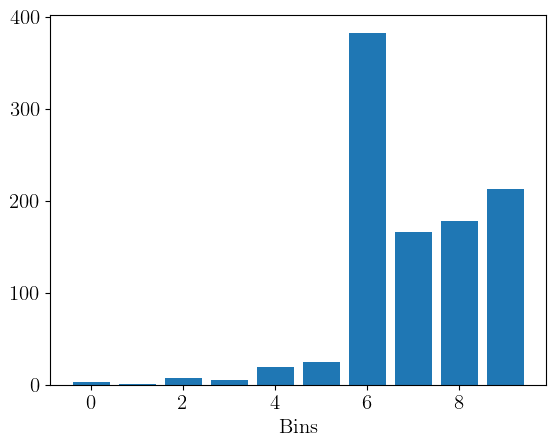

In [21]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [22]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=28.01807454839127, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [23]:
with open("./M/RUN2/N/LSGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()


## End of Part I
---



---



---



## **$\mathcal{U}(0,1) \to \mathcal{N}(-200,1)$**

### Vanilla GAN


In [24]:
!rm -r Log2
!mkdir Log2
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)



data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 1000/1000] [Batch 80/80] [D loss: 0.000693] [G Loss: 6.614191] [Generated: 0.265776]

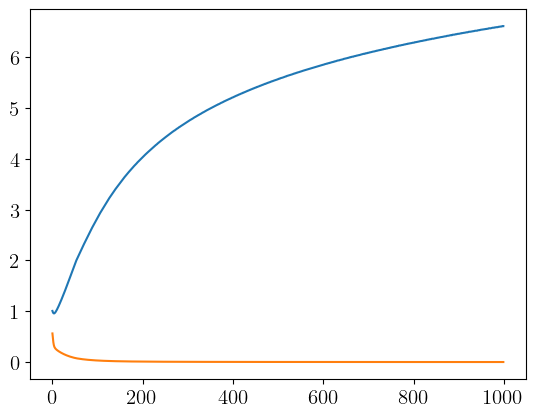

In [25]:

epochs = 1000
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.random(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        real_loss = adversarial_loss(discriminator(f), lbl_one)
        fake_loss = adversarial_loss(discriminator(f_tilde), lbl_zero)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(f_tilde.detach()), lbl_one)
        g_loss.backward()
        optimizer_G.step()
        if (e%10 == 0):
            torch.save(generator, "./Log/Generaor_%d"%(e))

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis

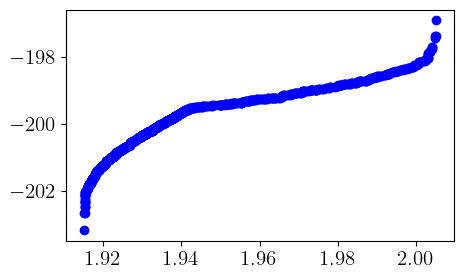

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [26]:
noisetype = "Uniform(0,1)"
GAN = "Vanilla GAN"

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

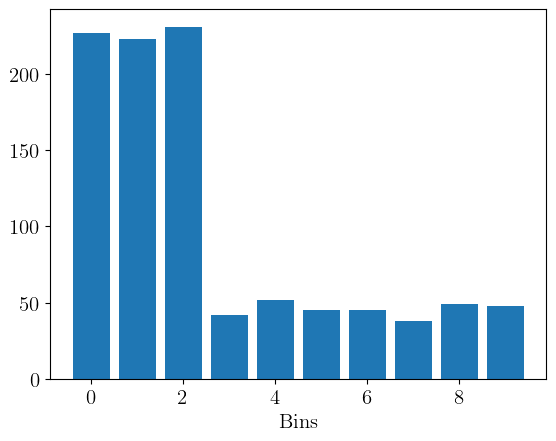

In [27]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [28]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=51.2263779595246, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [29]:
with open("./M/RUN2/U(0,1)toN(-200,1)/VGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### W-GAN

In [30]:

generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.000000] [G Loss: -0.549834] [Generated: 0.139665]

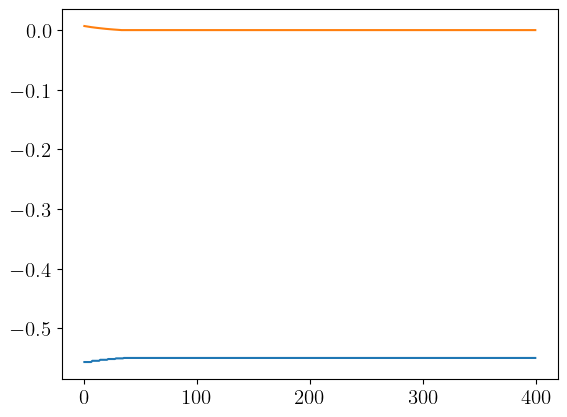

In [31]:

epochs = 400
gloss, dloss = [], []
clip_value = 0.2
n_critic = 7


batches_done = 0
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        z = Variable(Tensor(np.random.random(size=dimn)))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Generate a batch of images
        f_tilde = generator(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(discriminator(f)) + torch.mean(discriminator(f_tilde))

        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if e % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            f_tilde = generator(z)
            # Adversarial loss
            g_loss = -torch.mean(discriminator(f_tilde))

            g_loss.backward()
            optimizer_G.step()

        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))

        batches_done += 1
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of W-GAN

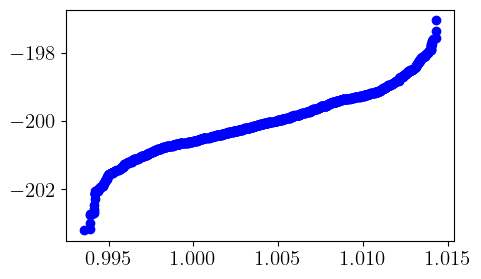

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [32]:
noisetype = "Uniform(0,1)"
GAN = "W-GAN"

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s GAN'%(noisetype, 1400, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

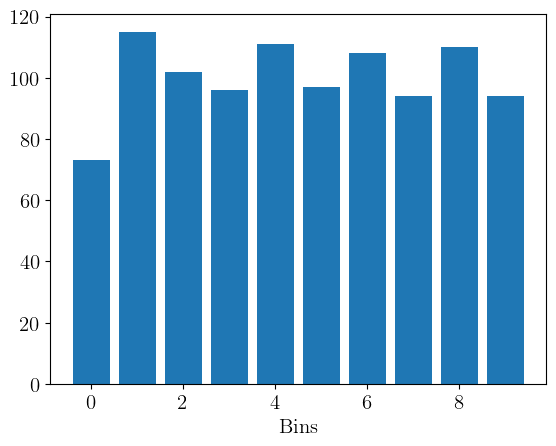

In [33]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [34]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=11.14350584372471, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [35]:
with open("./M/RUN2/U(0,1)toN(-200,1)/WGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### LS-GAN

In [36]:
'https://github.com/meliketoy/LSGAN.pytorch/blob/master/main.py'
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


# data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1, normalize=True)
data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1, normalize=False)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.051231] [G Loss: 0.319901] [Generated: -0.105206]

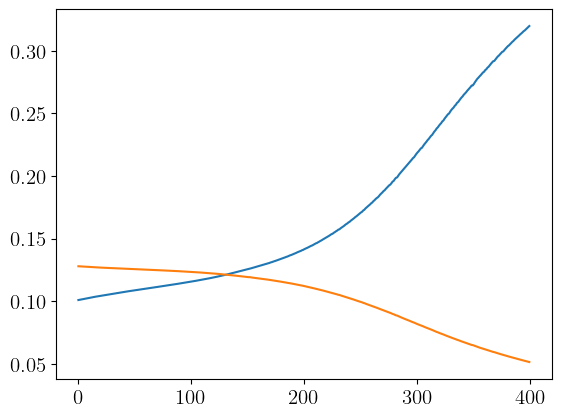

In [37]:

epochs = 400
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.random(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        errD_real = 0.5 * torch.mean((discriminator(f) - lbl_one)**2)
        errD_fake = 0.5 * torch.mean((discriminator(f_tilde) - lbl_zero)**2)
        d_loss = (errD_fake + errD_real) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = 0.5 * torch.mean((discriminator(f_tilde.detach()) - lbl_one)**2) # criterion(output, label)
        g_loss.backward()
        optimizer_G.step()

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of LSGAN

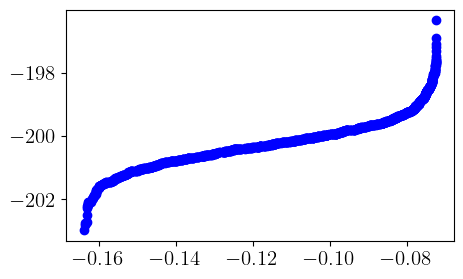

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [38]:
noisetype = "Uniform(0,1)"
GAN = "LSGAN"

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() # * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() # * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 1) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

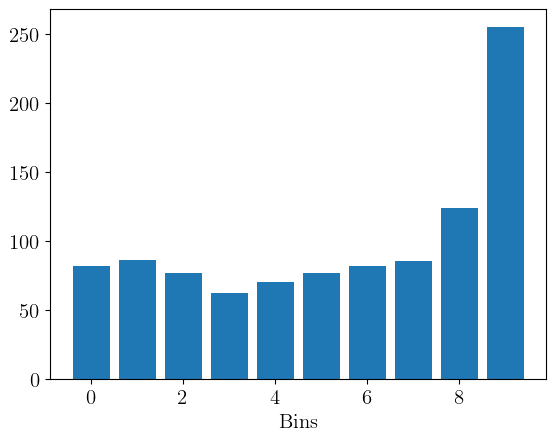

In [39]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [40]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=29.870833362345138, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [41]:
with open("./M/RUN2/U(0,1)toN(-200,1)/LSGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

## End of Part II

---

---

## **$\mathcal{N}(0,1) \to \mathcal{N}(-200,5)$**

### Vanilla GAN


In [42]:
!rm -r Log2
!mkdir Log2
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)



data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=5)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 1000/1000] [Batch 80/80] [D loss: 0.001037] [G Loss: 6.263639] [Generated: -0.368259]

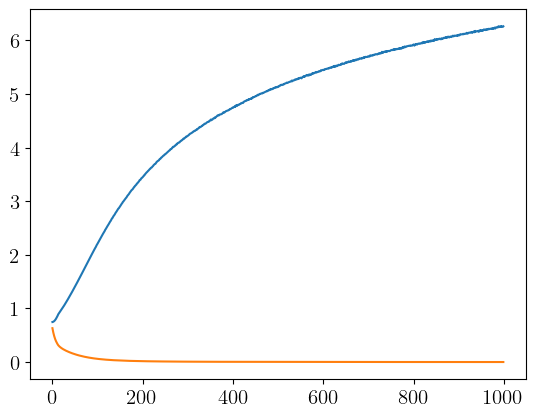

In [43]:

epochs = 1000
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.normal(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        real_loss = adversarial_loss(discriminator(f), lbl_one)
        fake_loss = adversarial_loss(discriminator(f_tilde), lbl_zero)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(f_tilde.detach()), lbl_one)
        g_loss.backward()
        optimizer_G.step()
        if (e%10 == 0):
            torch.save(generator, "./Log/Generaor_%d"%(e))

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis

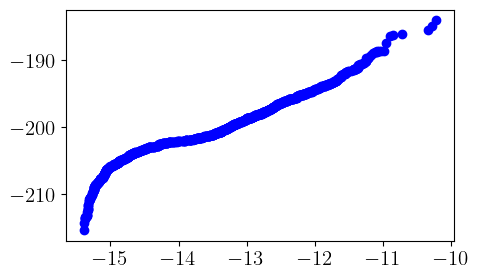

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [44]:
noisetype = "Normal(0,1)"
GAN = "Vanilla GAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 5) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

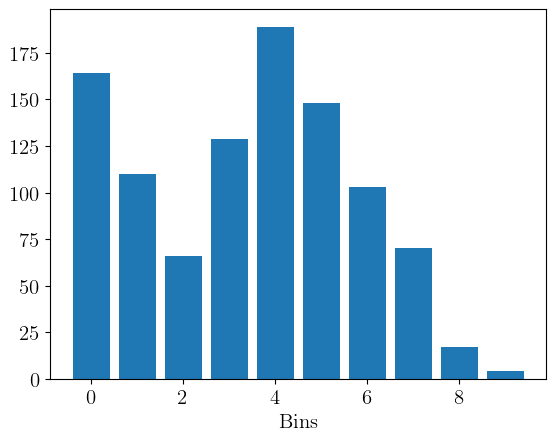

In [45]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [46]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=11.114374477532238, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [47]:
with open("./M/RUN2/N-N(m,s)/VGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### W-GAN

In [48]:

generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=5)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: -0.072614] [G Loss: -0.477602] [Generated: -0.999983]

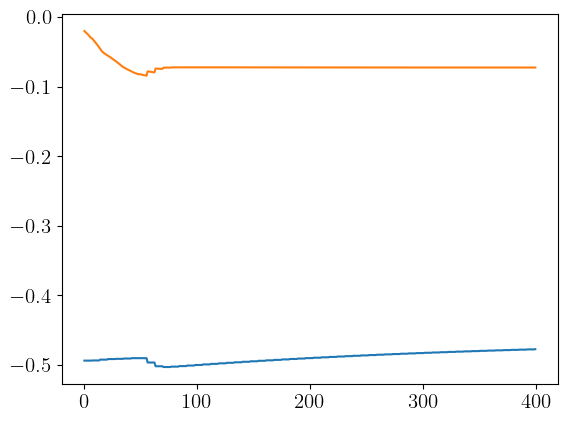

In [49]:

epochs = 400
gloss, dloss = [], []
clip_value = 0.2
n_critic = 7


batches_done = 0
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        z = Variable(Tensor(np.random.normal(size=dimn)))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Generate a batch of images
        f_tilde = generator(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(discriminator(f)) + torch.mean(discriminator(f_tilde))

        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if e % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            f_tilde = generator(z)
            # Adversarial loss
            g_loss = -torch.mean(discriminator(f_tilde))

            g_loss.backward()
            optimizer_G.step()

        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))

        batches_done += 1
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of W-GAN

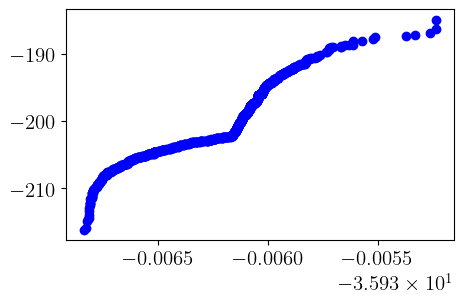

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [50]:
noisetype = "Normal(0,1)"
GAN = "W-GAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 5) \n after %d Epochs using %s GAN'%(noisetype, 1400, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

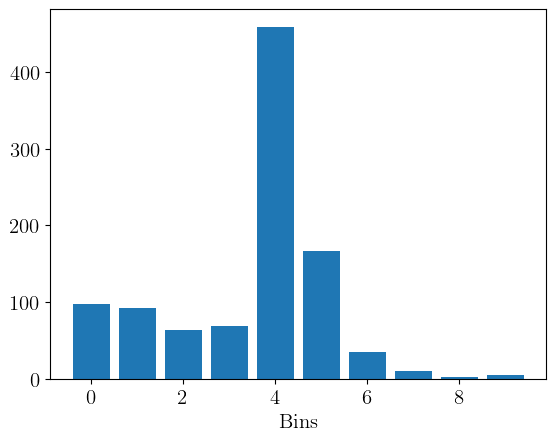

In [51]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [52]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=47.2851630791788, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [53]:
with open("./M/RUN2/N-N(m,s)/WGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### LS-GAN

In [54]:
'https://github.com/meliketoy/LSGAN.pytorch/blob/master/main.py'
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


# data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1, normalize=True)
data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=5, normalize=False)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.261529] [G Loss: 0.308316] [Generated: -0.342600]

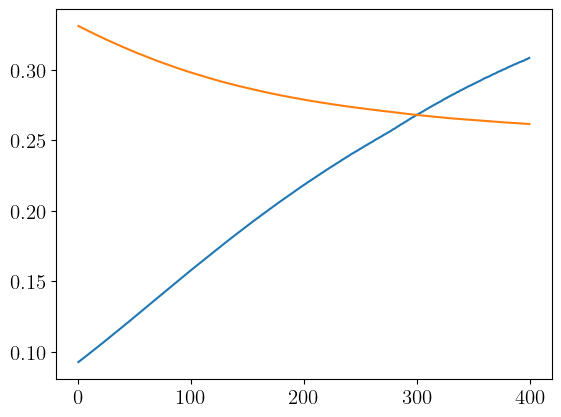

In [55]:

epochs = 400
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.normal(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        errD_real = 0.5 * torch.mean((discriminator(f) - lbl_one)**2)
        errD_fake = 0.5 * torch.mean((discriminator(f_tilde) - lbl_zero)**2)
        d_loss = (errD_fake + errD_real) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = 0.5 * torch.mean((discriminator(f_tilde.detach()) - lbl_one)**2) # criterion(output, label)
        g_loss.backward()
        optimizer_G.step()

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of LSGAN

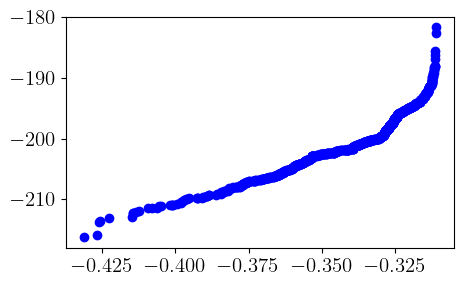

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [56]:
noisetype = "Normal(0,1)"
GAN = "LSGAN"

z = Variable(Tensor(np.random.normal(size=(1000,1))))
f_tilde = (generator(z)).flatten() # * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() # * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Target Data')
# plt.ylabel('Generated Data')
# plt.title('Given %s Noise Reach Normal(-200, 5) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

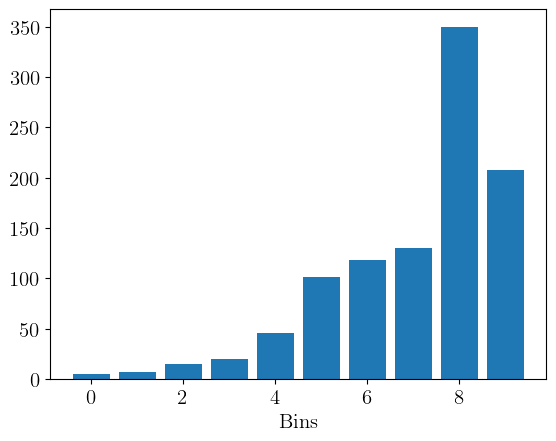

In [57]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [58]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=33.27249559085294, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [59]:
with open("./M/RUN2/N-N(m,s)/LSGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

## End of Part III

---

---

## **$\mathcal{U}(0,1) \to \mathcal{N}(0,1)$**

### Vanilla GAN


In [60]:
!rm -r Log2
!mkdir Log2
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)



data_loader = DataModule(dim=(100,50,1), f='gauss', mu=0, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

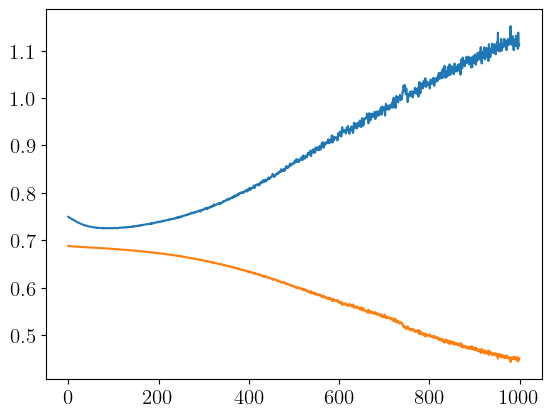

In [61]:

epochs = 1000
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.random(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        real_loss = adversarial_loss(discriminator(f), lbl_one)
        fake_loss = adversarial_loss(discriminator(f_tilde), lbl_zero)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(f_tilde.detach()), lbl_one)
        g_loss.backward()
        optimizer_G.step()
        if (e%10 == 0):
            torch.save(generator, "./Log/Generaor_%d"%(e))

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]\r"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis

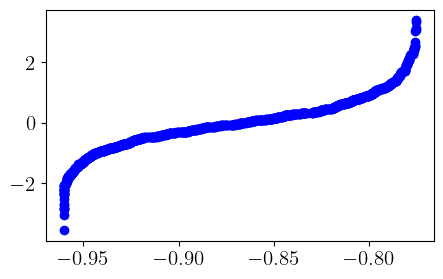

In [62]:
noisetype = "Uniform(0,1)"
GAN = "Vanilla GAN"
import statsmodels.api as sm 
import pylab as py 

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
# plt.xlabel('Generated Data')
# plt.ylabel('Target Data')
# plt.title('Given %s Noise Reach Normal(0, 1) \n after %d Epochs using %s'%(noisetype, epochs, GAN))
plt.show()

Text(0.5, 0, 'Bins')

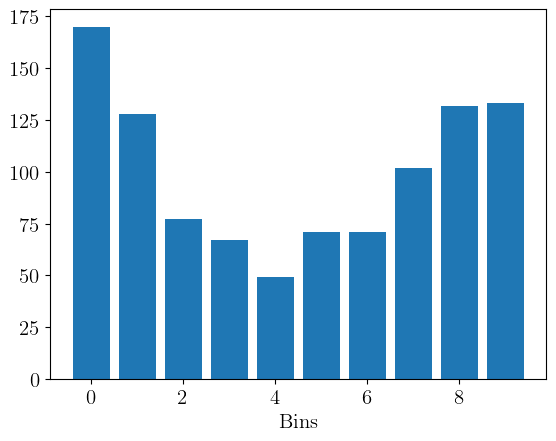

In [63]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [64]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=30.11019800663803, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [67]:
with open("./M/RUN2/U(0,1)toN(0,1)/VGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### W-GAN

In [68]:

generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


data_loader = DataModule(dim=(100,50,1), f='gauss', mu=0, sigma=1)
# data = DataModule(dim=(10,50,1), f='uniform', min=-12, max=500)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.000616] [G Loss: -0.434346] [Generated: 0.848967]]]

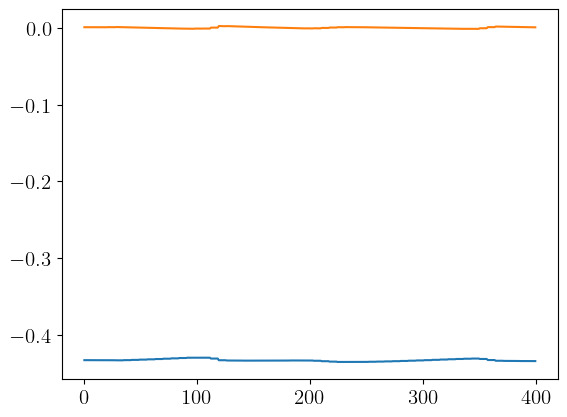

In [69]:

epochs = 400
gloss, dloss = [], []
clip_value = 0.2
n_critic = 7


batches_done = 0
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        z = Variable(Tensor(np.random.random(size=dimn)))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Generate a batch of images
        f_tilde = generator(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(discriminator(f)) + torch.mean(discriminator(f_tilde))

        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if e % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            f_tilde = generator(z)
            # Adversarial loss
            g_loss = -torch.mean(discriminator(f_tilde))

            g_loss.backward()
            optimizer_G.step()

        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))

        batches_done += 1
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of W-GAN

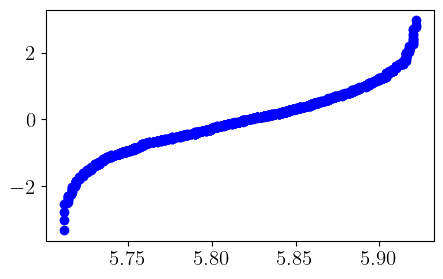

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [70]:
noisetype = "Uniform(0,1)"
GAN = "W-GAN"

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

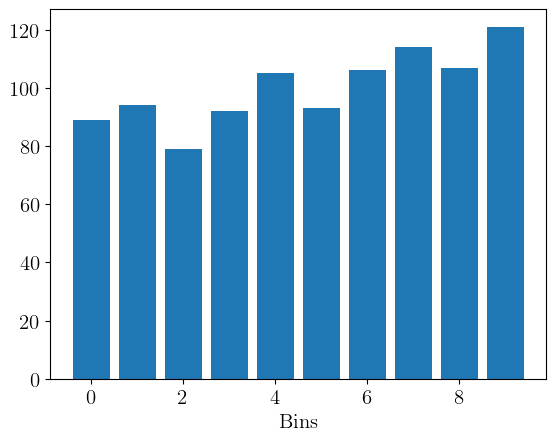

In [71]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [72]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=12.384525929564688, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [73]:
with open("./M/RUN2/U(0,1)toN(0,1)/WGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

### LS-GAN

In [74]:
'https://github.com/meliketoy/LSGAN.pytorch/blob/master/main.py'
generator = Generator()
discriminator = Discriminator()


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-3)


# data_loader = DataModule(dim=(100,50,1), f='gauss', mu=-200, sigma=1, normalize=True)
data_loader = DataModule(dim=(100,50,1), f='gauss', mu=0, sigma=1, normalize=False)
Xt_train, Xt_test = data_loader.X_train, data_loader.X_test

[Epoch 400/400] [Batch 80/80] [D loss: 0.090829] [G Loss: 0.157147] [Generated: 0.398574]

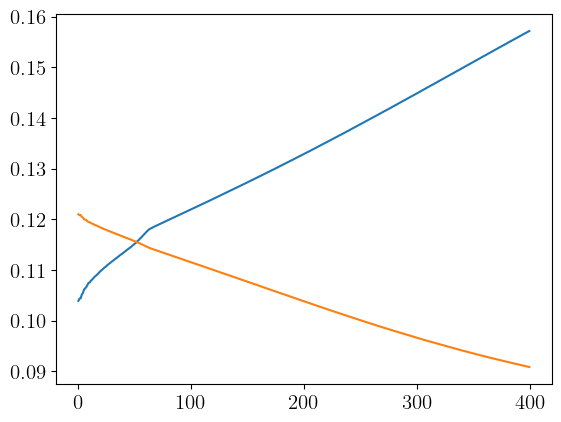

In [75]:

epochs = 400
gloss, dloss = [], []
for e in range(epochs):
    for b, f in enumerate(data_loader.X_train):
        dimn = (f.size(dim=0),  f.size(dim=1))

        lbl_one = Variable(Tensor(np.ones(dimn)), requires_grad=False)
        z = Variable(Tensor(np.random.random(size=dimn)))
        f_tilde = generator(z)

        optimizer_D.zero_grad()
        lbl_zero = Variable(Tensor(np.zeros(dimn)), requires_grad=False)
        errD_real = 0.5 * torch.mean((discriminator(f) - lbl_one)**2)
        errD_fake = 0.5 * torch.mean((discriminator(f_tilde) - lbl_zero)**2)
        d_loss = (errD_fake + errD_real) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = 0.5 * torch.mean((discriminator(f_tilde.detach()) - lbl_one)**2) # criterion(output, label)
        g_loss.backward()
        optimizer_G.step()

        # accuracy = Accuracy()
        # b_acc = accuracy(discriminator(f_tilde.detach())>=0.5, lbl_zero.type(torch.int8))
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%
                         (e+1, epochs, b+1, len(Xt_train), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
        # sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G Loss: %f] [Generated: %f]"%\
                        # (e+1, epochs, b+1, len(data_loader), d_loss.item(), g_loss.item(), torch.mean(f_tilde)))
    gloss.append(g_loss.item())
    dloss.append(d_loss.item())

plt.plot(range(epochs), gloss)
plt.plot(range(epochs), dloss)
plt.show()

#### Analysis of LSGAN

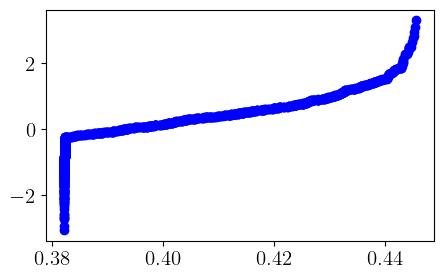

'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

In [76]:
noisetype = "Uniform(0,1)"
GAN = "LSGAN"

z = Variable(Tensor(np.random.random(size=(1000,1))))
f_tilde = (generator(z)).flatten() # * data_loader.scale
x1 = f_tilde.cpu().detach().numpy()
x2 = Xt_test.flatten().cpu().detach().numpy() # * data_loader.scale
import scipy.stats as stats
fig = plt.figure(figsize=(5,3))
x1.sort()
x2.sort()
plt.scatter(x1, x2, label='Direct QQ-plot on Tar vs Gen', color='blue')
plt.show()
'https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py'

Text(0.5, 0, 'Bins')

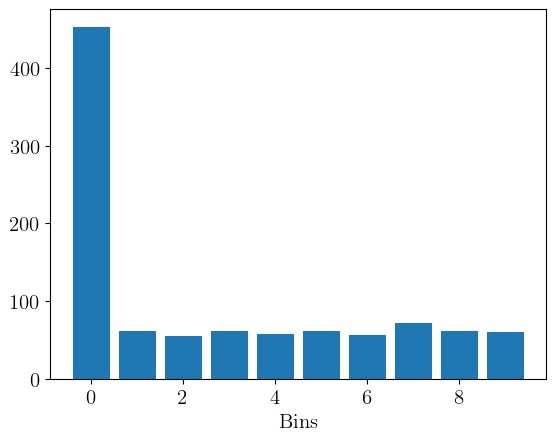

In [77]:
# x1 = (x1+200)/500
hist = torch.histc(torch.tensor(x1), bins=10, min=x1.min(), max=x1.max())
bins = 10
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Bins')

In [78]:
stats.anderson(x1, dist='norm')

AndersonResult(statistic=68.16592066073281, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [79]:
with open("./M/RUN2/U(0,1)toN(0,1)/LSGAN.txt", "w") as f:
    for x, y in zip(x1, x2):
        f.write(str(x) + ',' + str(y)+ '\n')
f.close()

## End of Part IV

---

---